<a href="https://colab.research.google.com/github/Rusdi2/Bangkit-Capstone-CR-02/blob/master/Model_Bandwidth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Membaca data dari file CSV
data = pd.read_csv('Bandwidth Data.csv')
data = data.rename(columns={'Bandwidth Receive (Mbps)': 'Bandwidth'})
data.head()


,No,Waktu,Bandwidth
0,1,2023-12-15 09:46:04,0.08
1,2,2023-12-15 09:46:09,0.14
2,3,2023-12-15 09:46:14,0.21
3,4,2023-12-15 09:46:19,0.29
4,5,2023-12-15 09:46:24,0.35


In [ ]:
data['Waktu'] = data['Waktu'].str.replace(' WIB\+0700', '')
data.head()

<ipython-input-5-61bbb098810c>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data['Waktu'] = data['Waktu'].str.replace(' WIB\+0700', '')


,No,Waktu,Bandwidth
0,1,2023-12-15 09:46:04,0.08
1,2,2023-12-15 09:46:09,0.14
2,3,2023-12-15 09:46:14,0.21
3,4,2023-12-15 09:46:19,0.29
4,5,2023-12-15 09:46:24,0.35


In [ ]:
# Memilih fitur untuk deteksi anomali
feature_data = data['Bandwidth'].values.reshape(-1, 1)  # Memastikan dimensi cocok untuk Autoencoder

# Normalisasi data
max_value = np.max(feature_data)
feature_data = feature_data / max_value

# Membagi data menjadi data latih dan validasi
train_size = int(len(feature_data) * 0.8)
train_data, val_data = feature_data[:train_size], feature_data[train_size:]

# Membangun model Autoencoder
input_data = Input(shape=(1,))
encoded = Dense(8, activation='relu')(input_data)
decoded = Dense(1, activation='sigmoid')(encoded)

autoencoder = Model(input_data, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Melatih model Autoencoder
autoencoder.fit(train_data, train_data,
                epochs=10,
                batch_size=32,
                validation_data=(val_data, val_data))

# Prediksi data menggunakan Autoencoder
reconstructed_data = autoencoder.predict(feature_data)

# Menghitung loss antara data asli dan rekonstruksi
mse = np.mean(np.power(feature_data - reconstructed_data, 2), axis=1)

# Menetapkan threshold untuk deteksi anomali
threshold = 0.01  # Threshold dapat disesuaikan

# Menandai data yang merupakan anomali
anomalies = data[mse > threshold]
print("Data Anomali:")
print(anomalies)

autoencoder.summary()


Epoch 1/10
13/13 [==============================] - 1s 19ms/step - loss: 0.0617 - val_loss: 0.0965
Epoch 2/10
13/13 [==============================] - 0s 7ms/step - loss: 0.0589 - val_loss: 0.1057
Epoch 3/10
13/13 [==============================] - 0s 5ms/step - loss: 0.0568 - val_loss: 0.1120
Epoch 4/10
13/13 [==============================] - 0s 6ms/step - loss: 0.0552 - val_loss: 0.1146
Epoch 5/10
13/13 [==============================] - 0s 4ms/step - loss: 0.0538 - val_loss: 0.1159
Epoch 6/10
13/13 [==============================] - 0s 4ms/step - loss: 0.0525 - val_loss: 0.1150
Epoch 7/10
13/13 [==============================] - 0s 5ms/step - loss: 0.0513 - val_loss: 0.1149
Epoch 8/10
13/13 [==============================] - 0s 5ms/step - loss: 0.0501 - val_loss: 0.1130
Epoch 9/10
13/13 [==============================] - 0s 6ms/step - loss: 0.0488 - val_loss: 0.1099
Epoch 10/10
16/16 [==============================] - 0s 1ms/step
Data Anomali:
      No                Waktu  Bandwid

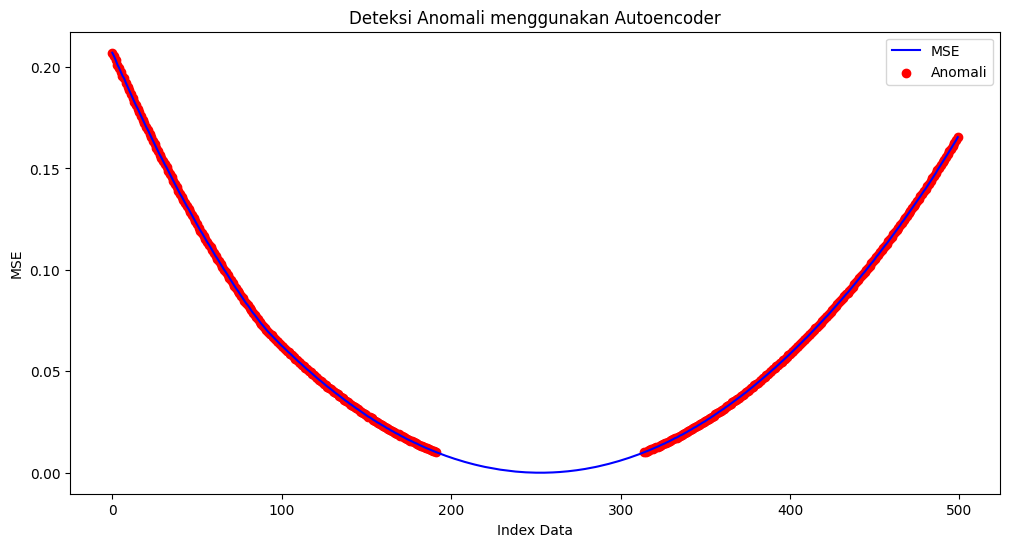

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data.index, mse, label='MSE', color='blue')
plt.scatter(anomalies.index, mse[mse > threshold], label='Anomali', color='red')
plt.xlabel('Index Data')
plt.ylabel('MSE')
plt.title('Deteksi Anomali menggunakan Autoencoder')
plt.legend()
plt.show()


In [ ]:
# Simpan model ke file
autoencoder.save('model_band.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model

# Memuat kembali model dari file
loaded_autoencoder = load_model('model_band.h5')

# Contoh penggunaan model yang dimuat kembali
reconstructed_data = loaded_autoencoder.predict(feature_data)


16/16 [==============================] - 0s 2ms/step


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import psutil
import numpy as np
import time
from datetime import datetime
import pytz

# Load the model and scaler
loaded_model = load_model('model_band.h5')  # Ganti dengan nama model yang sesuai
scaler = MinMaxScaler()

# Function to get real-time bandwidth receive
def get_real_time_bandwidth_receive():
    net_io = psutil.net_io_counters()
    return net_io.bytes_recv / 1024 / 1024  # Menghitung dalam Mbps

# Function to normalize real-time bandwidth receive
def normalize_bandwidth_receive_data(bandwidth_value):
    return scaler.transform(np.array(bandwidth_value).reshape(-1, 1))

# Function to predict using the loaded model
def predict_real_time_data(bandwidth_value):
    return loaded_model.predict(bandwidth_value.reshape(1, -1))

# Function to detect anomalies in bandwidth receive
def detect_anomaly(bandwidth_value):
    threshold = 0.5  # Sesuaikan dengan threshold yang sesuai
    bandwidth_value_scaled = normalize_bandwidth_receive_data(bandwidth_value)
    predicted = predict_real_time_data(bandwidth_value_scaled)

    if predicted > threshold:
        return "Anomaly"
    else:
        return "Not Anomaly"

# combine real-time bandwidth receive data with anomaly detection in real-time
def combine_real_time_data():
    wib = pytz.timezone('Asia/Jakarta')

    initial_bandwidth_receive = get_real_time_bandwidth_receive()
    initial_bandwidth_receive_scaled = scaler.fit_transform(np.array(initial_bandwidth_receive).reshape(-1, 1))

    while True:
        bandwidth_receive_data = get_real_time_bandwidth_receive()
        bandwidth_receive_data_scaled = normalize_bandwidth_receive_data(bandwidth_receive_data)  # Scale the data

        anomaly_result = detect_anomaly(bandwidth_receive_data)  # Detect anomaly

        # Get the local time in the WIB
        current_time = datetime.now(wib).strftime("%Y-%m-%d %H:%M:%S")

        # Print the combined result of real-time data, local time, and anomaly detection
        print(f"{current_time} - \nBandwidth Receive: {bandwidth_receive_data} \nAnomaly?: {anomaly_result}")

        # Wait for 1 second before reading the next bandwidth receive data
        time.sleep(1)

# Run the function to combine real-time bandwidth receive data and anomaly detection
combine_real_time_data()


In [ ]:
# Menyimpan model setelah dilatih ulang
loaded_model.save('model_bandwidth.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
